# Assignment 3 | Main notebook 
---

In [289]:
import pandas as pd
import numpy as np
from files import p2vmap
import yaml
import torch  # NN -> our own P2V model
import torch.nn
import torch.nn.functional
from torch.utils import tensorboard
import os
import itertools
import warnings
import sklearn.manifold
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

## load files

In [290]:
baskets = pd.read_parquet('files/market-baskets.parquet').head(50_000)
del baskets["customer"]

In [291]:
len(baskets)

50000

In [292]:
with open('files/config-w2v.yaml') as file:
    config_w2v = yaml.full_load(file)
    
with open('files/config-p2vmap.yaml') as file:
    config_p2vmap = yaml.full_load(file)

In [293]:
#basket_list = p2vmap.baskets_df_to_list(x=baskets.head(1_000_000), **config_w2v["baskets_df_to_list"])

## Pipeline

In [294]:
#baskets_2 = baskets.head(10_000)
#baskets_2 = baskets[baskets.groupby("basket")["product"].transform("nunique") > 2]


# initiate streamer
data_stream_p2v = p2vmap.DataStreamP2V(
    data=baskets, **config_p2vmap["data"]["data_streamer"]
)

# use streamer
dl_train, dl_validation = p2vmap.build_data_loader(
    streamer=data_stream_p2v,
    config=config_p2vmap["data"],
)

## Functions for classes

In [295]:
def get_loss(wi_center, wo_positive_samples, wo_negative_samples):

    logits_positive_samples = torch.einsum("ij,ij->i", (wi_center, wo_positive_samples))
    logits_negative_samples = torch.einsum("ik,ijk->ij", (wi_center, wo_negative_samples))

    loss_positive_samples = torch.nn.functional.binary_cross_entropy_with_logits(
        input=logits_positive_samples,
        target=torch.ones_like(logits_positive_samples),
        reduction="sum",
    )

    loss_negative_samples = torch.nn.functional.binary_cross_entropy_with_logits(
        input=logits_negative_samples,
        target=torch.zeros_like(logits_negative_samples),
        reduction="sum",
    )

    n_samples = logits_positive_samples.shape[0] * (logits_negative_samples.shape[1] + 1)
    main_loss = (loss_positive_samples + loss_negative_samples) / n_samples
    return main_loss

## Classes (the actual assignment)

In [296]:
class P2V(torch.nn.Module):
    
    def __init__(self, n_products, size):
        
        super().__init__()

        # add trainable variables here
        self.wi = torch.nn.Embedding(n_products, size, sparse=True)
        with torch.no_grad():
            self.wi.weight.uniform_(-0.025, 0.025)
            
        self.wo = torch.nn.Embedding(n_products, size, sparse=True)
        with torch.no_grad():
            self.wo.weight.uniform_(-0.025, 0.025)
                     
    def forward(self, center, context, negative_samples):
        
        # embed products (center, context, negative_samples)
        wi_center = self.wi(center)
        wo_positive_samples = self.wo(context)
        wo_negative_samples = self.wo(negative_samples)
        
        return get_loss(wi_center, wo_positive_samples, wo_negative_samples)

In [297]:
n_products = baskets['product'].nunique()
size = config_p2vmap['p2v']['size']
batch_size = config_p2vmap['data']['train']
n_negative_samples = config_p2vmap['data']['data_streamer']['n_negative_samples']

In [298]:
class TrainerP2V:
    
    def __init__(self, model, train, validation, path, n_batch_log=500):
        
        self.model = P2V(n_products, size) #model  # put your model here (via __init__ method)
        self.train = train
        self.validation = validation
        self.optimizer = torch.optim.SparseAdam(params=list(model.parameters()))
        self.path = path
        os.makedirs(f"{path}/weights")
        self.writer_train = torch.utils.tensorboard.SummaryWriter(f"{self.path}/runs/train")
        self.writer_val = torch.utils.tensorboard.SummaryWriter(f"{self.path}/runs/val")
        self.n_batch_log = n_batch_log
        self.global_batch = 0
        self.epoch = 0
        self.batch = 0

    def fit(self, n_epochs):

        for _ in range(n_epochs):
            
            print(f"epoch = {self.epoch}")

            for ce, co, ns in self.train:
                self.batch += 1
                self.global_batch += 1

                # add training steps here:
                self.optimizer.zero_grad()
                loss_train = self.model(ce, co, ns)
                loss_train.backward()
                self.optimizer.step()
                self.writer_train.add_scalar("loss", loss_train, self.global_batch)

    
                if self.batch % self.n_batch_log == 1:
                    self._callback_batch()

            #self._callback_epoch()
            self.epoch += 1

        self.writer_train.flush()
        self.writer_train.close()
        self.writer_val.flush()
        self.writer_val.close()

    def _callback_batch(self):
        # validation loss
        self.model.eval()
        with torch.no_grad():
            list_loss_validation = []
            for ce, co, ns in self.validation:
                list_loss_validation.append(self.model(ce, co, ns).item())
            loss_validation = np.mean(list_loss_validation)
        self.writer_val.add_scalar("loss", loss_validation, self.global_batch)
        self.model.train()

        # save weights
        np.save(
            f"{self.path}/weights/wi_{self.epoch:02d}_{self.batch:06d}.npy",
            self.get_wi(),
        )

        np.save(
            f"{self.path}/weights/wo_{self.epoch:02d}_{self.batch:06d}.npy",
            self.get_wo(),
        )

    def get_wi(self):
        return self.model.wi.weight.detach().numpy()

    def get_wo(self):
        return self.model.wo.weight.detach().numpy()

In [300]:
p2v  = P2V(300,25) 
#This is where i initiate the model (generate weights)

model = TrainerP2V(p2v, train=dl_train, validation=dl_validation, path='files')
#This is where i make the model trainable (inserting in the trainer class)

model.fit(n_epochs=10)
#This is where i actually train the model (weight updating happens here)

epoch = 0
epoch = 1
epoch = 2
epoch = 3
epoch = 4
epoch = 5
epoch = 6
epoch = 7
epoch = 8


KeyboardInterrupt: 

## Try-out

## Weights to plot

In [301]:
x = model.model.wi.weight.detach().numpy()  # pd dataframe -> np array
x /= np.linalg.norm(x, axis=1)[:, np.newaxis]  # normalize
res_tsne = sklearn.manifold.TSNE(**config_w2v["TSNE"]).fit_transform(x)

In [302]:
product = pd.DataFrame(
    {
        "product": list(range(300)),
        "category": np.repeat(range(20), 15),
    }
)

In [303]:
tsne_map_xy = pd.DataFrame(
    res_tsne,
    index=product[["category", "product"]].set_index(["category", "product"]).index,
    columns=["x", "y"],
).reset_index()

In [304]:
tsne_map_xy

,category,product,x,y
0,0,0,10.556911,73.616142
1,0,1,49.744534,0.921518
2,0,2,-33.436810,66.482651
3,0,3,-23.890635,68.372101
4,0,4,-13.068256,27.531305
...,...,...,...,...
295,19,295,-89.199173,-8.070350
296,19,296,-71.280190,12.436793
297,19,297,-51.672783,-62.461861
298,19,298,-33.310696,-19.920864


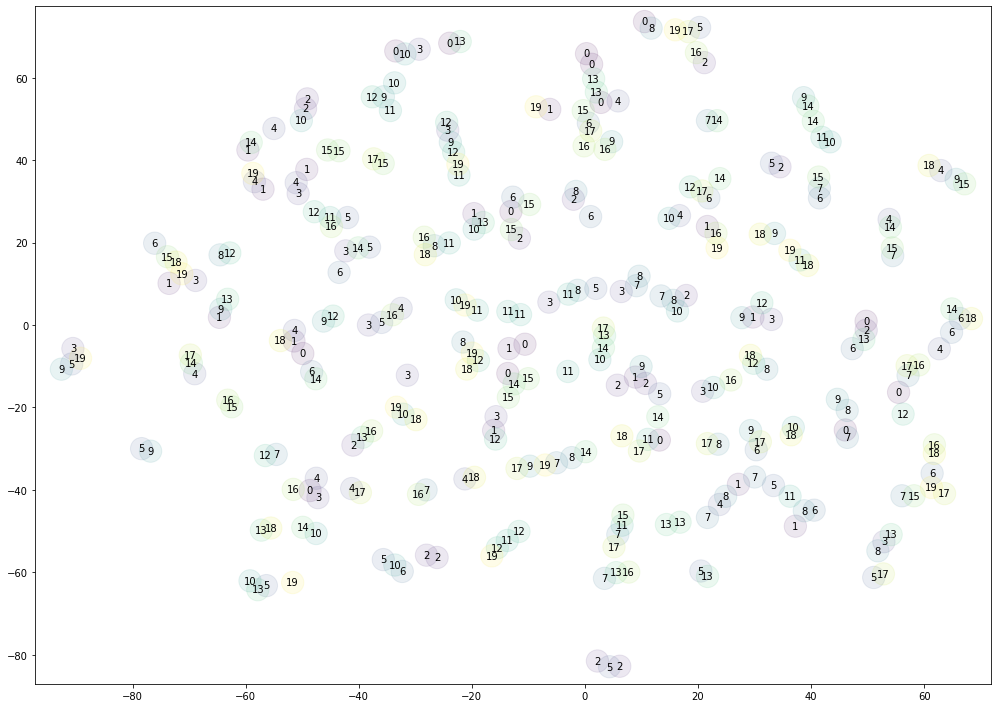

In [305]:
p2vmap.plot_tsne(tsne_map_xy, plotlabels=True, scatter=0)

In [306]:
tsne_map_xy

,category,product,x,y
0,0,0,10.556911,73.616142
1,0,1,49.744534,0.921518
2,0,2,-33.436810,66.482651
3,0,3,-23.890635,68.372101
4,0,4,-13.068256,27.531305
...,...,...,...,...
295,19,295,-89.199173,-8.070350
296,19,296,-71.280190,12.436793
297,19,297,-51.672783,-62.461861
298,19,298,-33.310696,-19.920864
